## Basic Nelder-Mead implementation

With thanks to https://github.com/fchollet/nelder-mead/blob/master/nelder_mead.py for the starting code

In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


In [4]:
def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5,
                verbose=False, return_steps=False):
    '''
        f (function): function to optimize, must return a scalar score
            and operate over a numpy array of the same dimensions as x_start
        x_start (list): initial position
        step (float): look-around radius in initial step
        no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
            an improvement lower than no_improv_thr
        max_iter (int): always break after this number of iterations.
            Set it to 0 to loop indefinitely.
        alpha, gamma, rho, sigma (floats): parameters of the algorithm
            (see Wikipedia page for reference)

        return: tuple (best parameter array, best score)
    '''

    # initial parameters
    # number of dimensions
    dim = len(x_start)

    # prev best score, i.e. score for initial guess
    prev_best = f(x_start)

    # number of iterations with no improvement
    no_improv = 0

    # array of results, updated each loop
    res = [[x_start, prev_best]]

    # create initial simplex
    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    if return_steps:
        simplexs = []

    # simplex iter
    iters = 0
    while True:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]
        if verbose:
            print(f"{iters}, scores: {[r[1] for r in res]}")
            print(f"{iters}, x: {[r[0] for r in res]}")

        if return_steps:
            simplexs.append([r[0] for r in res])
        
        # break after max_iter
        if max_iter and iters >= max_iter:
            if return_steps:
                return res[0][0], simplexs
            else:
                return res[0][0]
        iters += 1

        if verbose:
            print('...best so far:', best)

        # break after no_improv_break iterations with no improvement

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            if return_steps:
                return res[0][0], simplexs
            else:
                return res[0][0]

        # centroid
        # first create zeroes list of length dim
        x0 = [0.] * dim

        # then loop through all but last result, which is "worst" and will be ignored
        for tup in res[:-1]:
            this_x = tup[0]
            for i, x_i in enumerate(this_x):
                # for each dimension of x, add components of res[:-1], i.e. all but the worst
                # but divided by number of components, len(res[:1]), resulting in centroid
                # of all but "worst"
                x0[i] += x_i / (len(res)-1)

        # reflection
        # new point not better than previous best, but better than previous second worst
        # place test point as far from centroid as worst is from centroid
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            if verbose:
                print("reflected")
            res.append([xr, rscore])
            continue

        # expansion
        # new point now best, keep going in that direction
        # or see if going further in the direction of the worst point is better
        # note gamma = 2 x alpha
        if rscore < res[0][1]:
            if verbose:
                print("expanded")
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        # if we're here, going a distance alpha or gamma didn't find a better option
        # let's going less
        # rho = 1/2 x alpha
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        # the loop below mostly handles arbitrary dimensions, but is otherwise needlessly fancy
        # it keeps res[0], the current best, then adds points sigma (0.5 by default) distance 
        # between the best point and the other points of the simplex
        x1 = res[0][0]
        nres = []
        if verbose:
            print("contract")
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres

0, scores: [array([23.58868723]), array([23.97310687])]
0, x: [array([-4.9]), array([-5.])]
...best so far: [23.58868723]
expanded
1, scores: [array([22.08830476]), array([23.58868723])]
1, x: [array([-4.7]), array([-4.9])]
...best so far: [22.08830476]
expanded
2, scores: [array([16.93990817]), array([22.08830476])]
2, x: [array([-4.3]), array([-4.7])]
...best so far: [16.93990817]
expanded
3, scores: [array([4.29709454]), array([16.93990817])]
3, x: [array([-3.5]), array([-4.3])]
...best so far: [4.29709454]
expanded
4, scores: [array([-3.41614332]), array([4.29709454])]
4, x: [array([-1.9]), array([-3.5])]
...best so far: [-3.41614332]
5, scores: [array([-3.41614332]), array([-3.11559933])]
5, x: [array([-1.9]), array([-2.7])]
...best so far: [-3.41614332]
6, scores: [array([-3.94478057]), array([-3.41614332])]
6, x: [array([-2.3]), array([-1.9])]
...best so far: [-3.94478057]
7, scores: [array([-3.94478057]), array([-3.80675331])]
7, x: [array([-2.3]), array([-2.1])]
...best so far

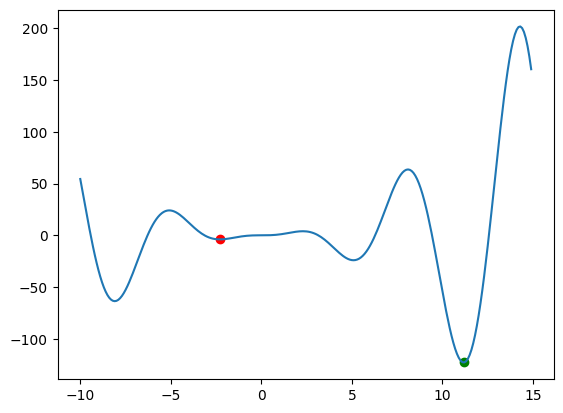

In [5]:
def f(x):
    return np.sin(x) * x **2

res1 = nelder_mead(f, np.array([-5.]), verbose=True)
res2 = nelder_mead(f, np.array([-5.]), step=5)

x_plot = np.arange(-10, 15, 0.1)

plt.plot(x_plot, f(x_plot))
plt.scatter(res1, f(res1), c="r")
plt.scatter(res2, f(res2), c="g")

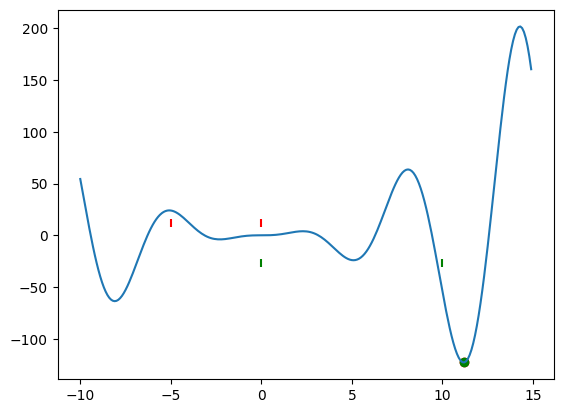

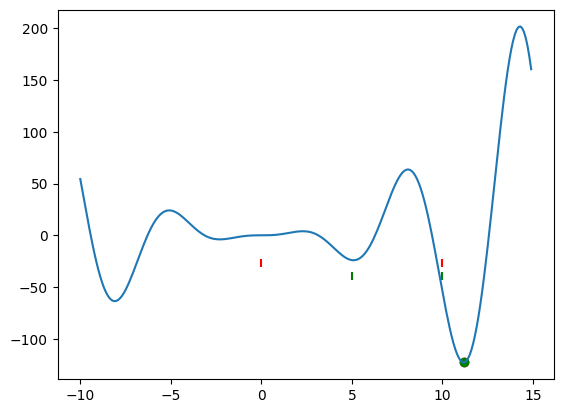

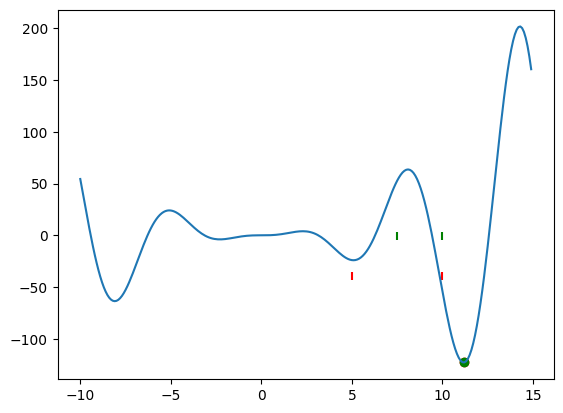

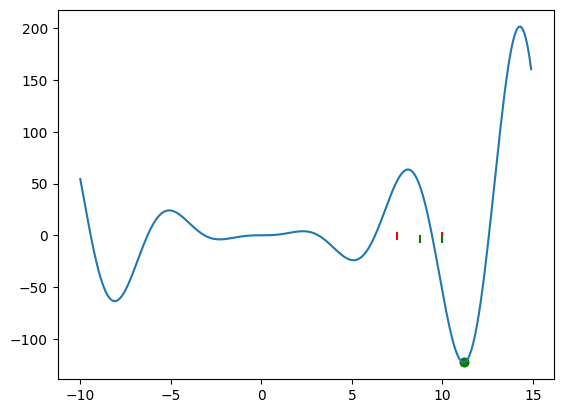

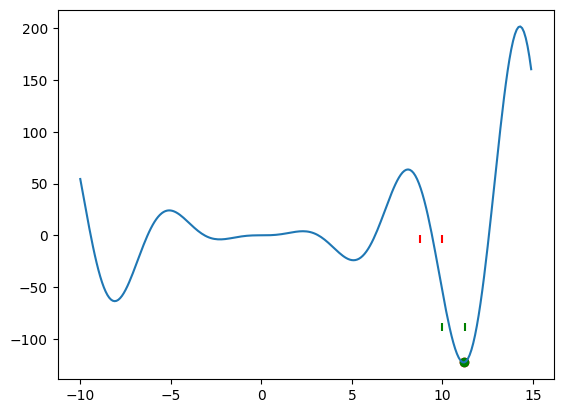

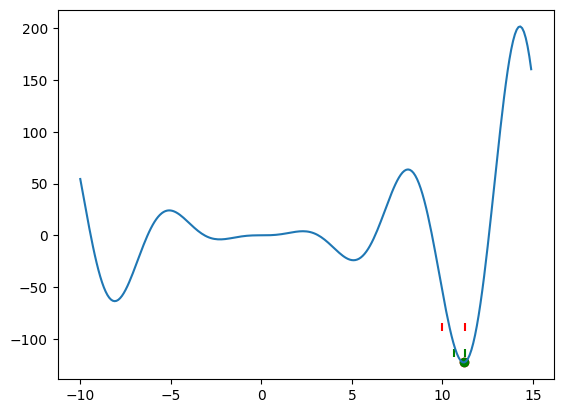

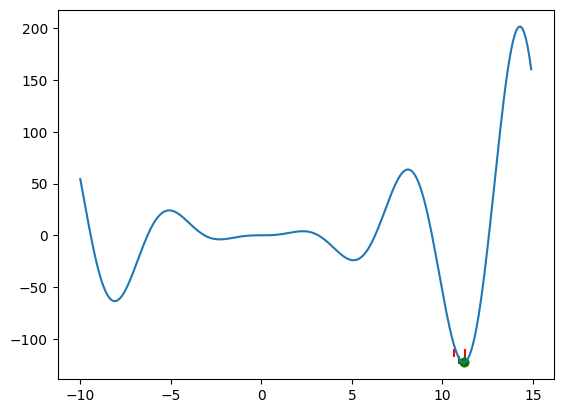

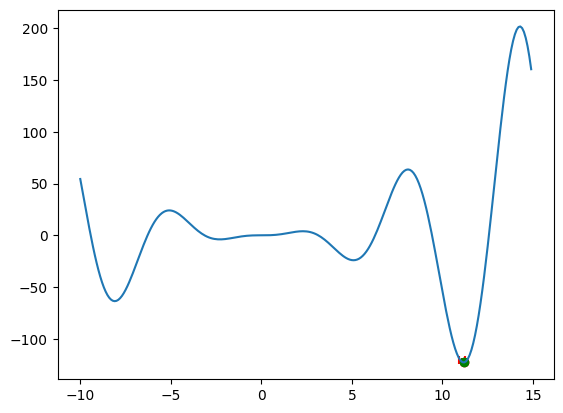

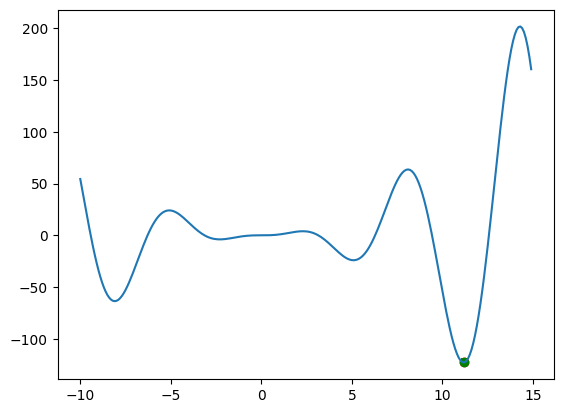

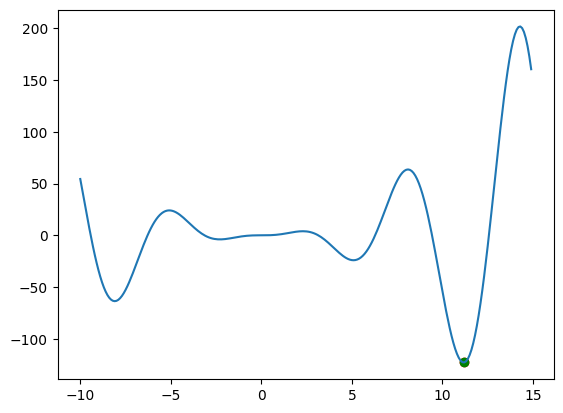

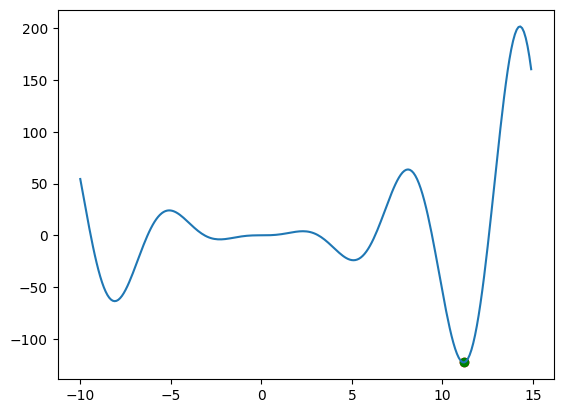

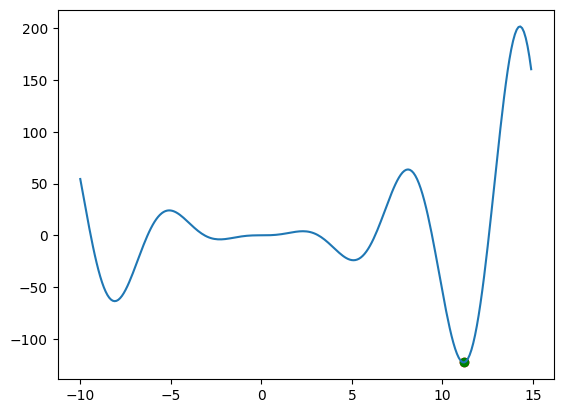

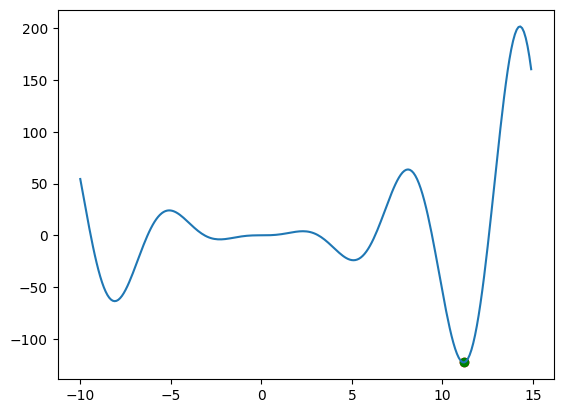

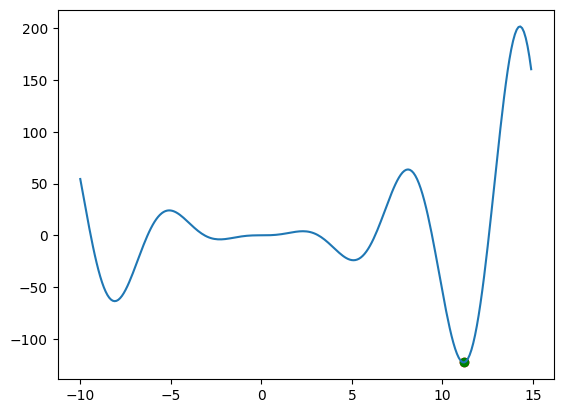

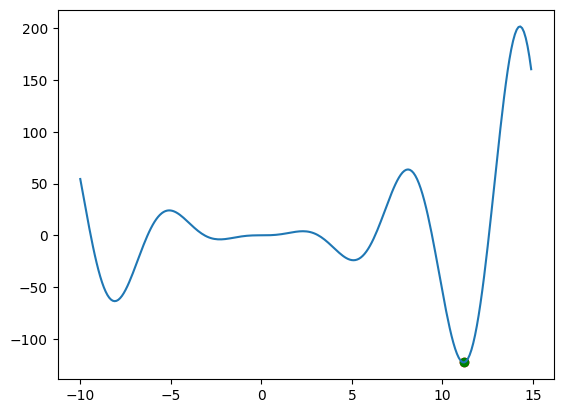

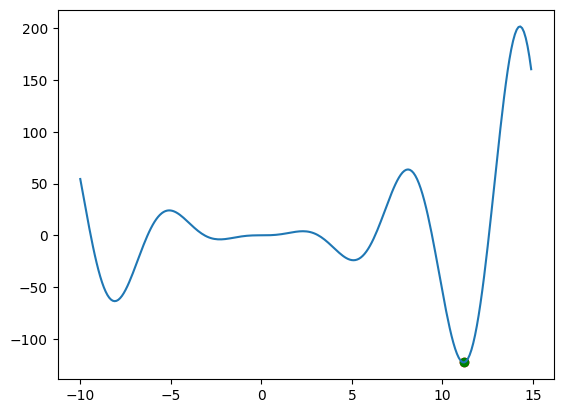

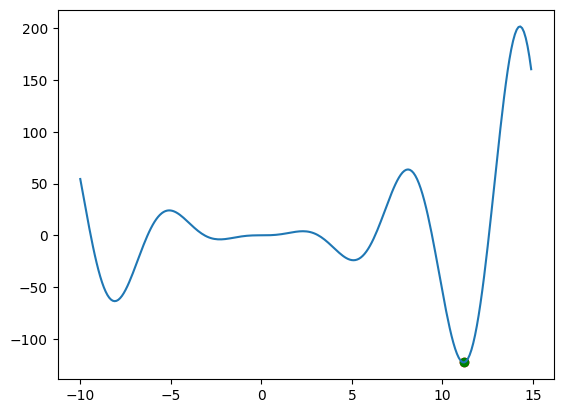

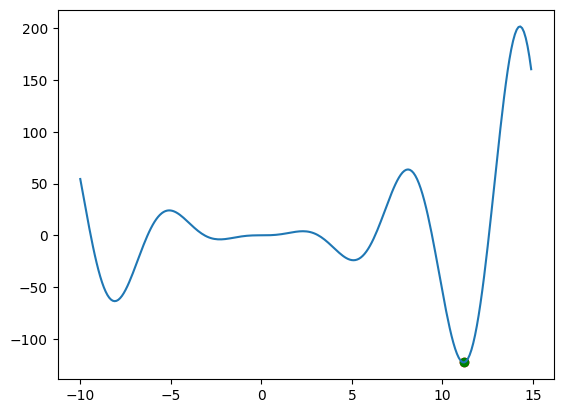

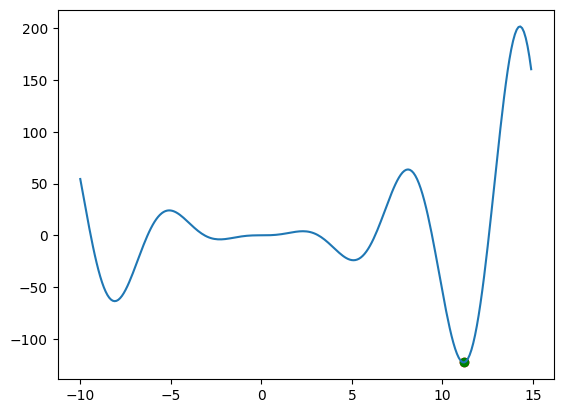

In [6]:
def f(x):
    return np.sin(x) * x **2

# res1 = nelder_mead(f, np.array([-5.]))
res, steps = nelder_mead(f, np.array([-5.]), step=5, no_improve_thr=0.01,return_steps=True)

for i in range(len(steps) - 1):
    plt.figure()
    step = steps[i]
    fstep = np.mean([f(x) for x in step])
    fstep = [fstep for x in step]
    plt.scatter(step, fstep, marker="|", c="r")
    
    next_step = steps[i+1]
    fnext = np.mean([f(x) for x in next_step])
    fnext = [fnext for x in next_step]
    plt.scatter(next_step, fnext, marker="|", c="g")

    x_plot = np.arange(-10, 15, 0.1)

    plt.plot(x_plot, f(x_plot))
    plt.scatter(res, f(res), c="r")
    plt.scatter(res2, f(res2), c="g")

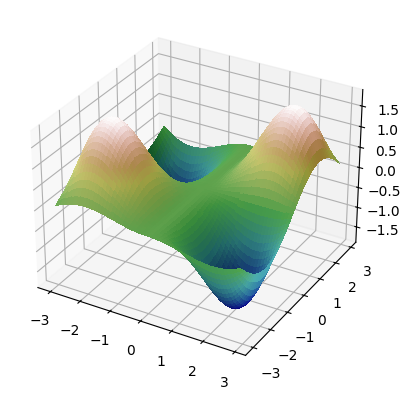

In [7]:
def f2(x):
    return np.sin(x[0]) * np.sin(x[1]) *np.abs(x[0])


x = np.arange(-3, 3, 0.1)
y = np.arange(-3, 3, 0.1)
x, y = np.meshgrid(x, y)

z = f2([x,y])

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

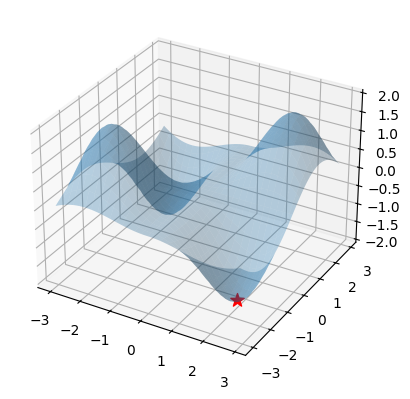

In [8]:
res, steps = nelder_mead(f2, np.array([-2, -2]), return_steps=True)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

surf = ax.plot_surface(x, y, z, alpha=0.3)

ax.scatter(res[0], res[1], f2(res), marker="*", s=100,color="r")

/var/folders/9g/cssdlht136q0kq9mp8w_8b1x5xl75p/T/ipykernel_39977/367232534.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))


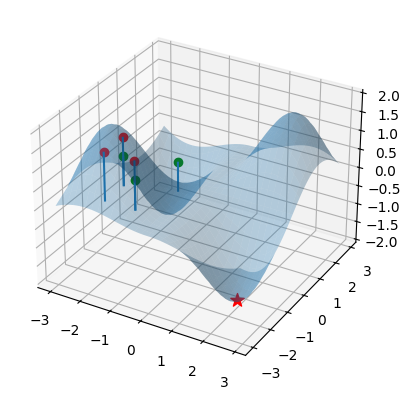

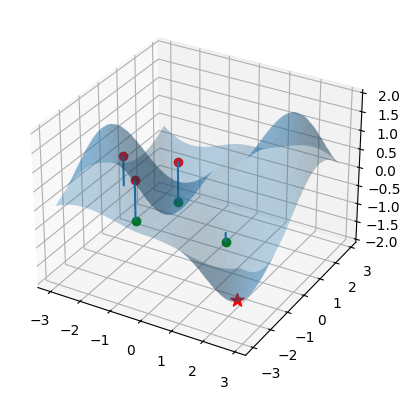

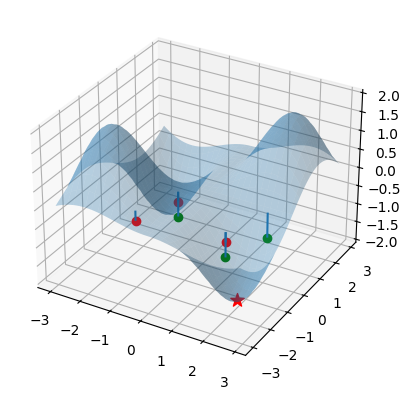

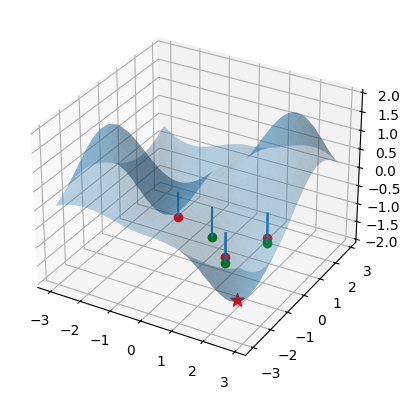

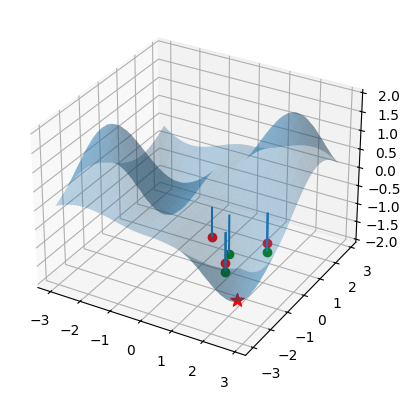

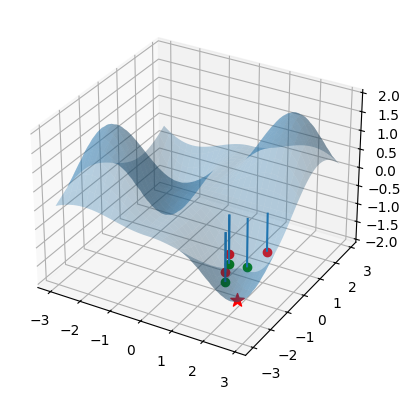

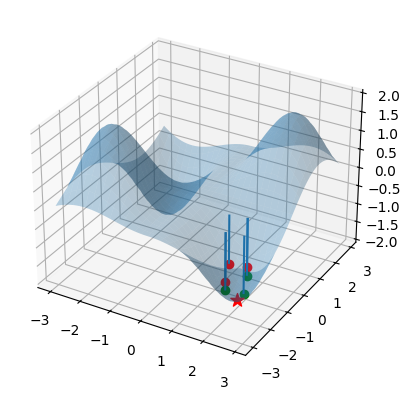

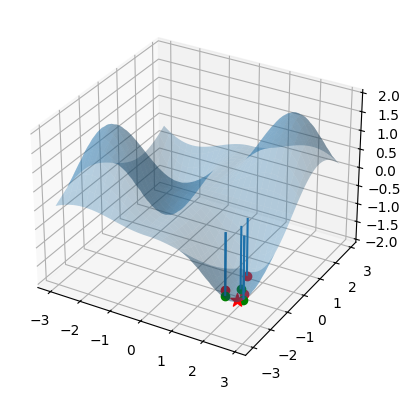

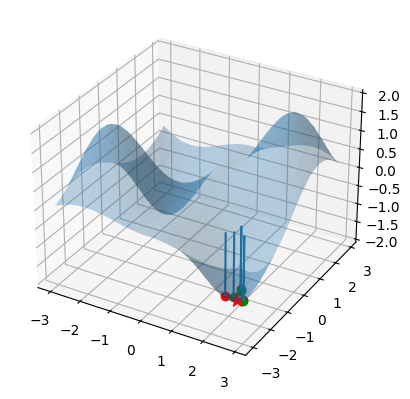

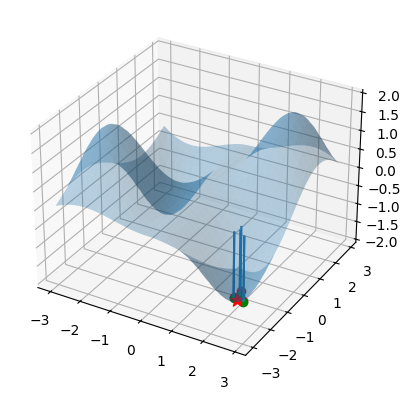

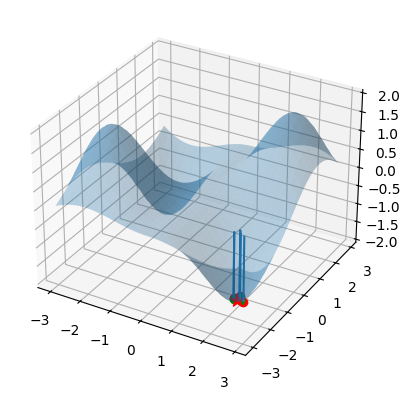

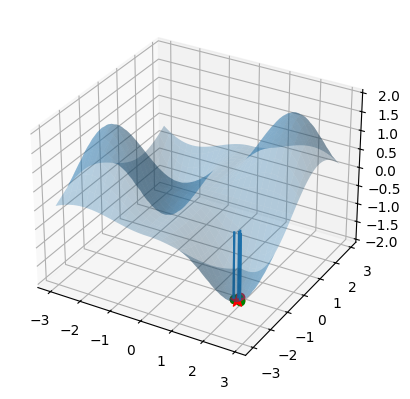

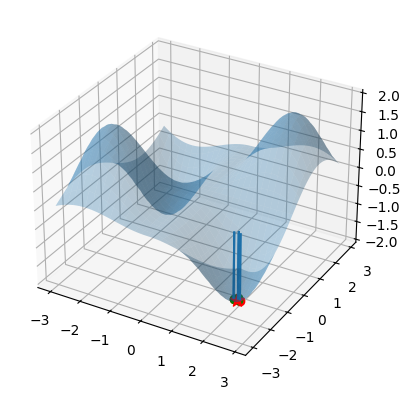

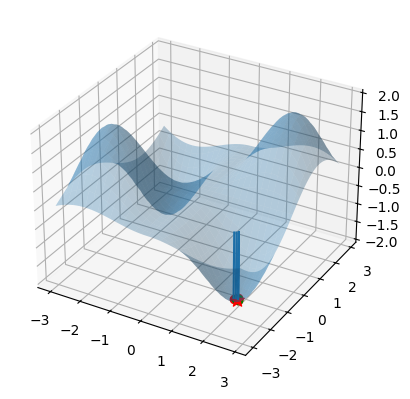

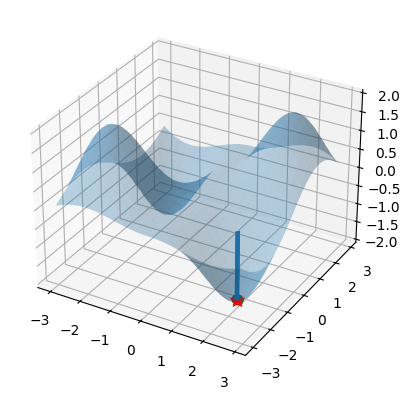

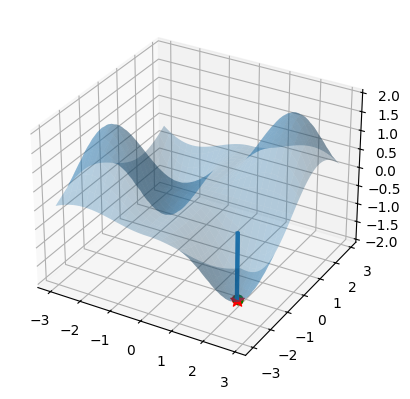

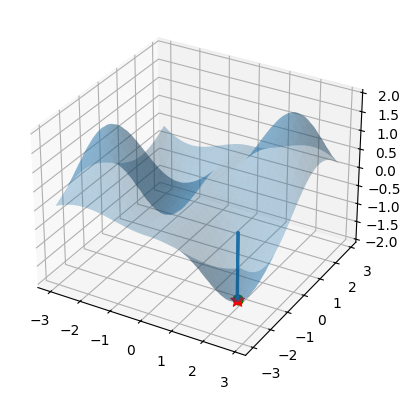

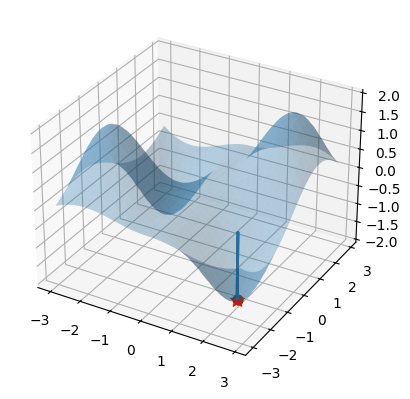

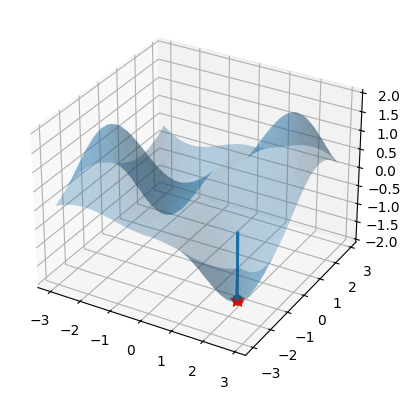

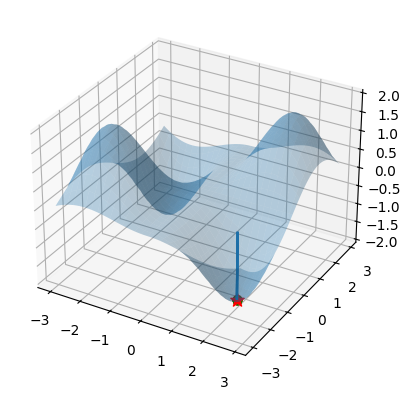

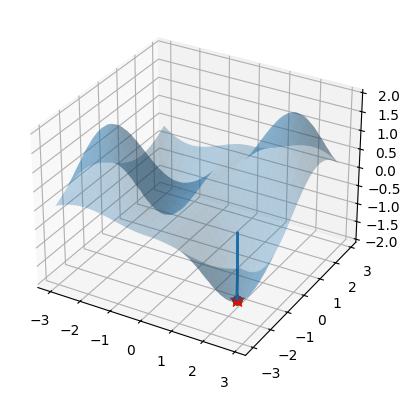

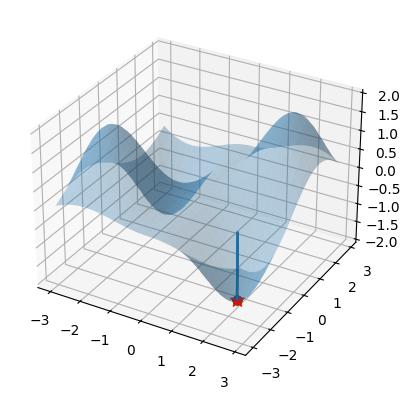

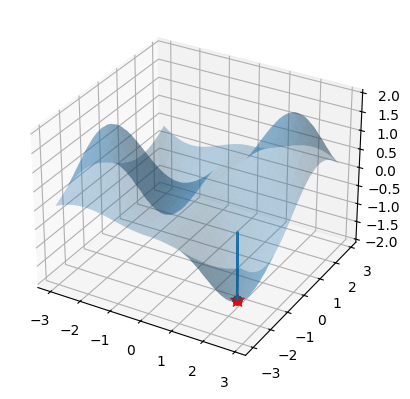

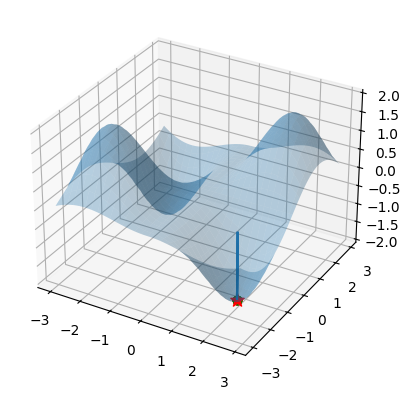

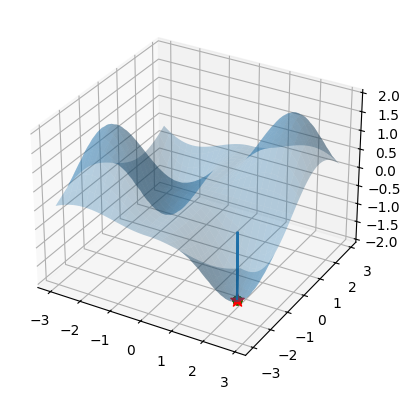

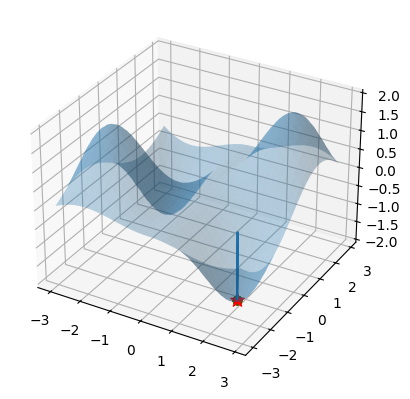

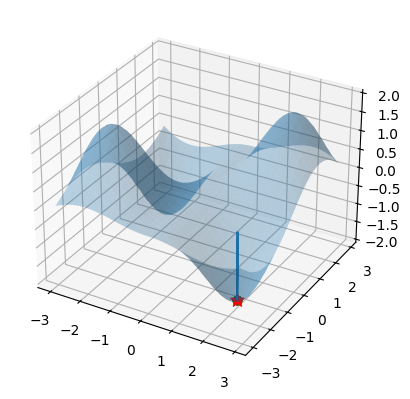

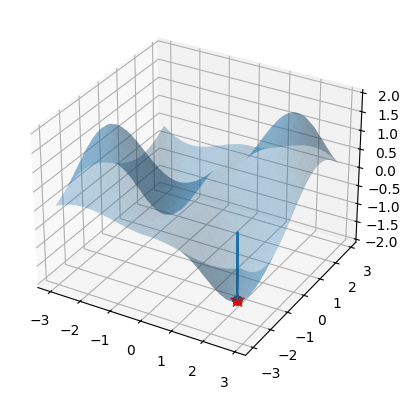

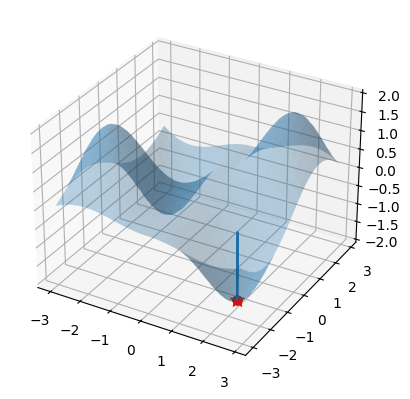

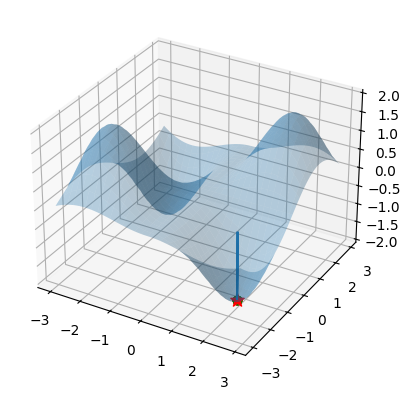

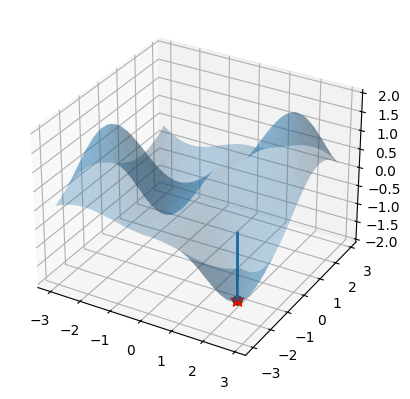

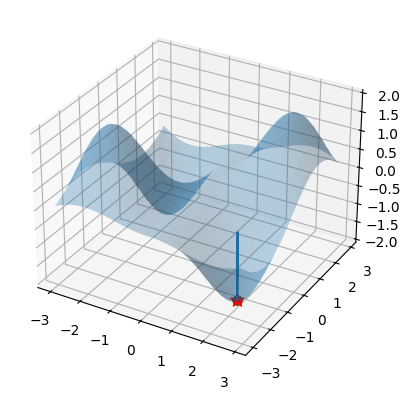

In [9]:
res, steps = nelder_mead(f2, np.array([-2, -2]), return_steps=True)

for i in range(len(steps) - 1):

    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

    surf = ax.plot_surface(x, y, z, alpha=0.3)

    step = steps[i]
    fstep = np.mean([f2(x) for x in step])
    fstep = [fstep for x in step]
    s_x = [s[0] for s in step]
    s_y = [s[1] for s in step]
    ax.stem(s_x, s_y, fstep, markerfmt="ro", basefmt=" ")
    
    next_step = steps[i+1]
    fnext = np.mean([f2(x) for x in next_step])
    fnext = [fnext for x in next_step]
    s_x = [s[0] for s in next_step]
    s_y = [s[1] for s in next_step]
    color = ["g" for r in step]
    ax.stem(s_x, s_y, fnext, markerfmt="go", basefmt=" ")

    x_plot = np.arange(-10, 15, 0.1)
    
    ax.scatter(res[0], res[1], f2(res), marker="*", s=100,color="r")